# Prepare the Data

[Download the Excel file here](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) on crime data in New York State in 2013, provided by the FBI: UCR ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

The 'population' variable is already set for you, but you will need to create the last three features.  Robbery and Murder are currently continuous variables.  For this model, please use these variables to create  categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0.  You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready.  Don't forget basic data cleaning procedures, either!  Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
from IPython.display import display
import math
from statsmodels.sandbox.regression.predstd import wls_prediction_std

pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls", skiprows=4,skip_footer=3)
df.head()

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\pandas\util\_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


## Data exploration

In [3]:
df.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,348.000,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,nan,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,nan,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,nan,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,nan,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,nan,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,nan,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [4]:
#print('Cities:\n', df['City'].unique())
print('Total number of cities:', len(df['City'].unique()))

Total number of cities: 348


## Clean the data set

In [5]:
# Remove the new lines in the column names
df1 = df
df1.columns= df1.columns.str.replace('\n',' ')

# Remove left and right white space from towns
df1.City = df1.City.str.lstrip()
df1.City = df1.City.str.rstrip()

# Drop unimportant variables
dfi = df1[['City','Population','Murder and nonnegligent manslaughter','Robbery','Property crime']]

# Check how many data is missing
def check_nans(dfi):
    for column in dfi.columns.unique():
        print(column,":",dfi[column].isnull().sum()/dfi.shape[0]*100 ,"% is Nan")

check_nans(dfi)

City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


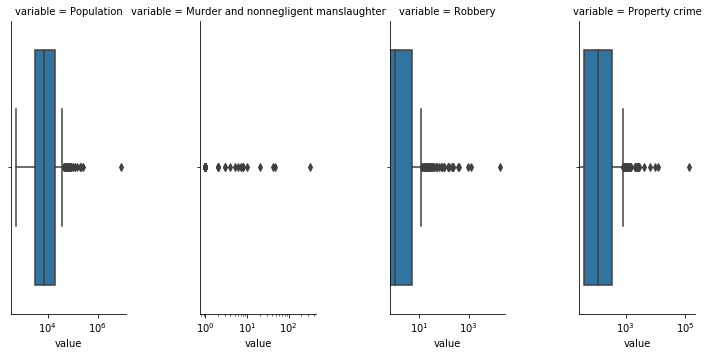

In [6]:
# Check for outliers in important variables
dfis = pd.melt(dfi, id_vars=['City'])
dfis.head()
g = sns.FacetGrid(dfis, col="variable",sharey=False,sharex=False, col_wrap=5, size=5, aspect=.5)
g = (g.map(sns.boxplot, "value"))
g=g.set(xscale="log")



No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


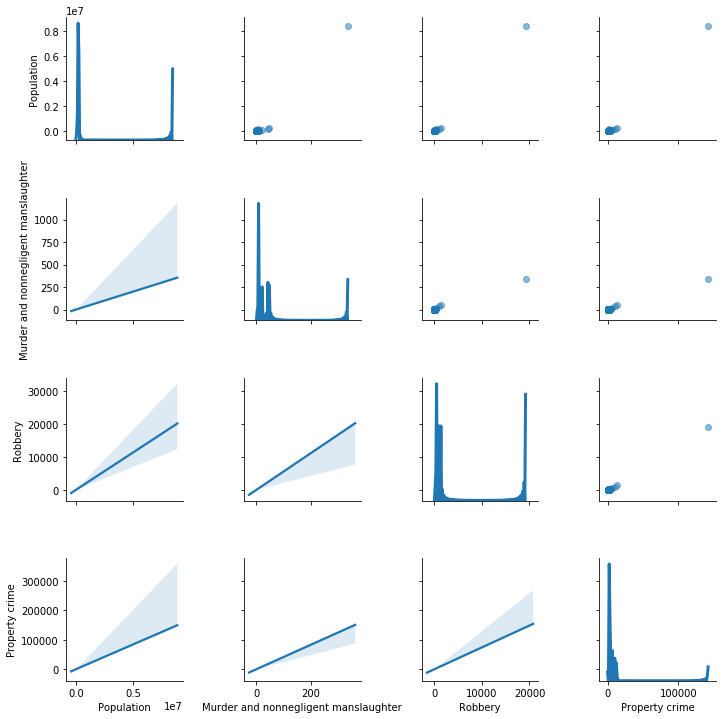

In [7]:
# Make a scatterplot matrix.
g = sns.PairGrid(dfi.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Variables are correlated.\n
Distribution of most variables are not normal, because of few high outliers. \n

In [8]:
# Sort data by population
dfi.sort_values(by=['Population'], ascending =False).head()

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime
216,New York,8396126,335,19170,141971
35,Buffalo,258789,47,1322,12491
272,Rochester,210562,42,918,10051
346,Yonkers,199134,6,390,2368
310,Syracuse,143834,21,400,6473


The highest outlier population-vice is New York. Therefore, I remove New York data.

In [9]:
# Remove New York data point
dfi_noNY= dfi[dfi['City'] != 'New York']
print(dfi_noNY.sort_values(by=['Population'], ascending =False).head())

             City  Population  Murder and nonnegligent manslaughter  Robbery  \
35        Buffalo      258789                                    47     1322   
272     Rochester      210562                                    42      918   
346       Yonkers      199134                                     6      390   
310      Syracuse      143834                                    21      400   
7    Amherst Town      118296                                     1       31   

     Property crime  
35            12491  
272           10051  
346            2368  
310            6473  
7              2118  


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


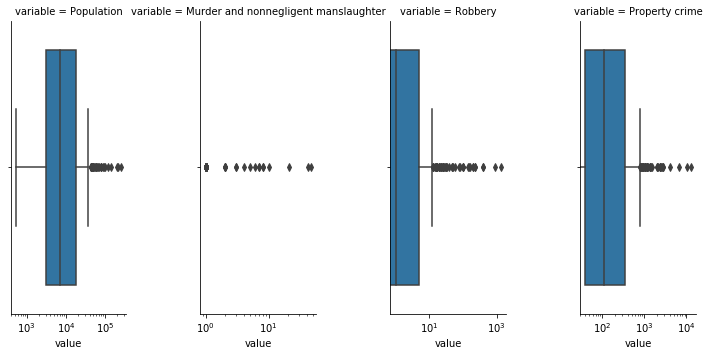

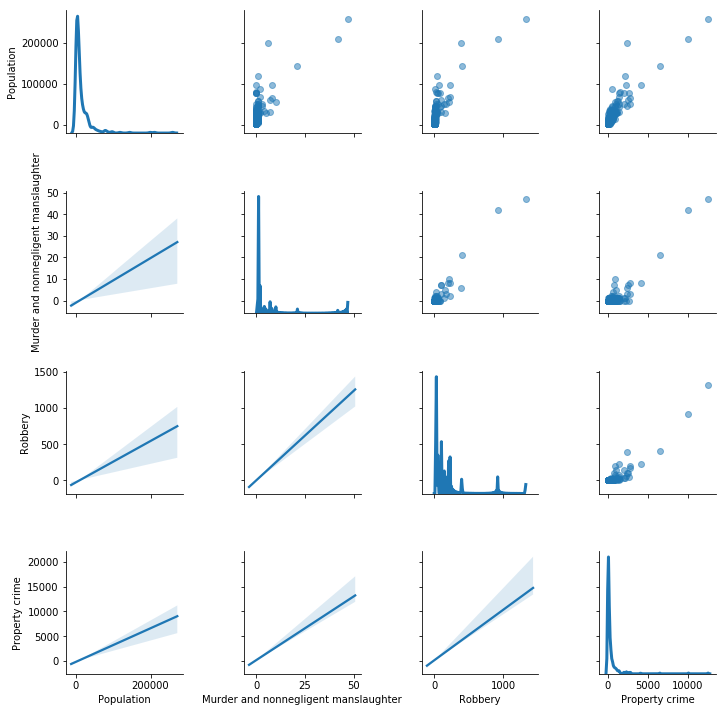

In [10]:
# Recheck data 
df2s = pd.melt(dfi_noNY, id_vars=['City'])
df2s.head()
g = sns.FacetGrid(df2s, col="variable",sharey=False,sharex=False, col_wrap=5, size=5, aspect=.5)
g = (g.map(sns.boxplot, "value"))
g=g.set(xscale="log")

# Make a scatterplot matrix.
g = sns.PairGrid(dfi_noNY.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

 Robbery and murder have outlier as well, but these variables will be converted into binaries anyway, therefore I ignore them.

## Generate new features

In [11]:
# Generate new features based on the instruction of the assignment
def gen_new_features(df):
    df['Population^2']=df['Population']**2
    df['Murder_Bi']=np.where(df['Murder and nonnegligent manslaughter']>0, 1, 0)
    df['Robbery_Bi']=np.where(df['Robbery']>0, 1, 0)
    return df
# Whole dataset
dfi_nF =  gen_new_features(dfi)
# Not corrected for outliers except for NY
dfi_noNY_nF =  gen_new_features(dfi_noNY)

dfi_noNY_nF.head()

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,City,Population,Murder and nonnegligent manslaughter,Robbery,Property crime,Population^2,Murder_Bi,Robbery_Bi
0,Adams Village,1861,0,0,12,3463321,0,0
1,Addison Town and Village,2577,0,0,24,6640929,0,0
2,Akron Village,2846,0,0,16,8099716,0,0
3,Albany,97956,8,227,4090,9595377936,1,1
4,Albion Village,6388,0,4,223,40806544,0,1


# Generate Model
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

Assignment: <br>
Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.<br>
<br>
You've already gotten started by prepping the FBI:UCR Crime dataset (Thinkful mirror) in a previous assignment.<br>
<br>
Using this data, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction rather han understanding mechanisms, so the focus is on creating a model that explains a lot of variance.<br>
<br>
Submit a notebook with your model and a brief writeup of your feature engineering and selection process to submit and review with your mentor.


Coefficients: 
 [[1.29510871e-02 1.14920528e-07 1.95038666e+02 9.28205845e+01]]

Intercept: 
 [-16.81586632]

R-squared: 
 0.8444937611173492
                   City  Population  Murder and nonnegligent manslaughter  \
346             Yonkers      199134                                     6   
267         Ramapo Town       87204                                     2   
7          Amherst Town      118296                                     1   
84   East Fishkill Town       29315                                     1   
127     Greenburgh Town       44787                                     1   

     Robbery  Property crime  Population^2  Murder_Bi  Robbery_Bi  residuals  
346      390            2368   39654349956          1           1  -5039.144  
267        9             567    7604537616          1           1  -1707.347  
7         31            2118   13993943616          1           1  -1293.297  
84         1             165     859369225          1           1   -584.464  

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


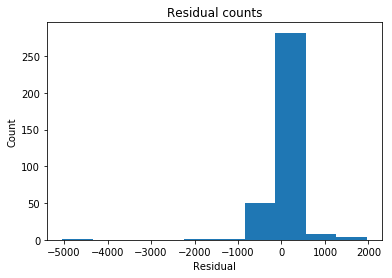

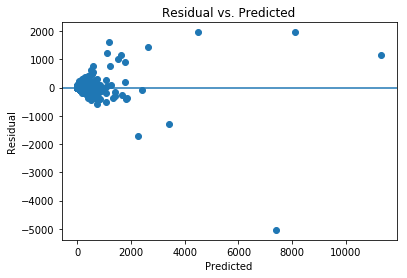

In [12]:
# Instantiate and fit model for outlier-corrected data
regr = linear_model.LinearRegression()
target = dfi_noNY['Property crime'].values.reshape(-1, 1) #Y
data = dfi_noNY[['Population','Population^2','Murder_Bi','Robbery_Bi']] #X

#data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=20)

regr.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(data, target))
# Extract predicted values.
predicted = regr.predict(data).ravel()
actual = dfi_noNY['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

#Check the -6000 outlier
dfi_noNY['residuals']=residual
print(dfi_noNY.sort_values(by=['residuals']).head())

# Error histogram
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Error scatter plot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [13]:
def run_model(df):    
    # Instantiate and fit model for outlier-corrected data
    regr = linear_model.LinearRegression()
    target = df['Property crime'].values.reshape(-1, 1) #Y
    data = df[['Population','Population^2','Murder_Bi','Robbery_Bi']] #X

    #data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=20)

    regr.fit(data, target)

    # Inspect the results.
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared: \n', regr.score(data, target))
    # Extract predicted values.
    predicted = regr.predict(data).ravel()
    actual = df['Property crime']

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Error histogram
    plt.hist(residual)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()

    # Error scatter plot
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()

                   City  Population  Murder and nonnegligent manslaughter  \
267         Ramapo Town       87204                                     2   
7          Amherst Town      118296                                     1   
84   East Fishkill Town       29315                                     1   
127     Greenburgh Town       44787                                     1   
117           Glen Cove       27134                                     0   

     Robbery  Property crime  Population^2  Murder_Bi  Robbery_Bi  residuals  
267        9             567    7604537616          1           1  -1707.347  
7         31            2118   13993943616          1           1  -1293.297  
84         1             165     859369225          1           1   -584.464  
127       16             578    2005875369          1           1   -503.600  
117        1              62     736253956          0           1   -450.030  

Coefficients: 
 [[1.32534368e-02 1.40349994e-07 1.87915055e+02

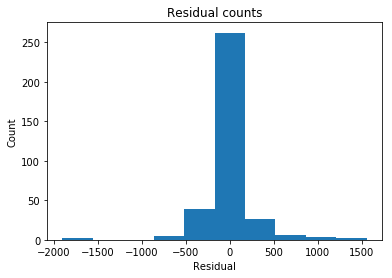

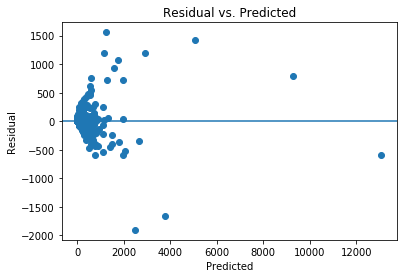

In [14]:
# Identified Yonkers as outlier -> remove
dfi_noNYJ = dfi_noNY.drop(index=346)
print(dfi_noNYJ.sort_values(by=['residuals']).head())
run_model(dfi_noNYJ)

# Test Model

## Assignment:<br>
Validating regression models for prediction<br>
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.<br>
<br>
The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.<br>
<br>
We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.<br>
<br>
Iterate<br>
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.<br>

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

## Statistical model evaluation

In [15]:
def rename_cols(df):
    df['PropertyCrime']=df['Property crime']
    df['Murder']=df['Murder and nonnegligent manslaughter']
    return df

dfi_noNYJ1 = rename_cols(dfi_noNYJ)
dfi_noNY1 = rename_cols(dfi_noNY)
#print(dfi_noNY1.head())

linear_formula= 'PropertyCrime~Population+Population^2+Murder_Bi+Robbery_Bi'#Population^2+Population^2+Murder_Bi+Robbery_Bi'
lm= smf.ols(formula=linear_formula, data= dfi_noNYJ1).fit()

print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:          PropertyCrime   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     466.5
Date:                Wed, 18 Jul 2018   Prob (F-statistic):          7.55e-137
Time:                        22:43:54   Log-Likelihood:                -2567.8
No. Observations:                 346   AIC:                             5146.
Df Residuals:                     341   BIC:                             5165.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -126.3761     34.909     -3.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The model as a whole has a significant p-value when performing the F-test, but only the Robbery_Bi feature has a significant p-value. The second warning indicates that the multicollinearity is problematic. All variables correlate with the population, the higher the population the higher the likelyhood for crimes in general. The convidence interval for alpha includes 0,there is warning of collinearity and the p-values is not significant (except for murder_bi) are not significant. This is not a good model.<br>
To make a new revised model, I tested each of the variables alone: population and population^2 both deliever R-squares of 0.78. Whereas the binary features of robbery and murder are not helpful with R^2 below 0.2.When introducing back other variables from the original data, numerical data for robbery and murder, robbery alone yields R^2=0.87, murder alone gives R^2=0.84.<br>
When combining murder with population R^2 = 0.92 and both features get significant p-values. When combining robbery with population R^2 = 0.91 and both features get significant p-values.The combination of robbery, murder and population yields R^2 of 0.93, therefore I will use the following revised model:<br>
<br>
$$ Property crime = \alpha + Population + Murder(numerical) + Robbery(numerical)$$
<br>


In [16]:
# Test revised model
linear_formula= 'PropertyCrime ~ Population + Robbery + Murder'#Population^2+Population^2+Murder_Bi+Robbery_Bi'
lm= smf.ols(formula=linear_formula, data= dfi_noNYJ1).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:          PropertyCrime   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     2232.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):          3.68e-224
Time:                        22:43:54   Log-Likelihood:                -2367.7
No. Observations:                 346   AIC:                             4743.
Df Residuals:                     342   BIC:                             4759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.4303     15.836     -0.785      0.4

## Test revised model on crime data from other states

In [17]:
# Test data sets
Cali = pd.read_excel("table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls",skiprows=4,skip_footer=2)
#print(Cali.tail())
Con = pd.read_excel("table_8_offenses_known_to_law_enforcement_connecticut_by_city_2013.xls",skiprows=4,skip_footer=2)
#print(Con.tail())
Geor = pd.read_excel("table_8_offenses_known_to_law_enforcement_georgia_by_city_2013.xls",skiprows=4,skip_footer=3)
#print(Geor.tail())
Louis = pd.read_excel("table_8_offenses_known_to_law_enforcement_louisiana_by_city_2013.xls",skiprows=4,skip_footer=3)
NoDa = pd.read_excel("table_8_offenses_known_to_law_enforcement_north_dakota_by_city_2013.xls",skiprows=4,skip_footer=2)
SoDa = pd.read_excel("table_8_offenses_known_to_law_enforcement_south_dakota_by_city_2013.xls",skiprows=4,skip_footer=2)
Okla = pd.read_excel("table_8_offenses_known_to_law_enforcement_oklahoma_by_city_2013.xls",skiprows=4,skip_footer=2)
Wash = pd.read_excel("table_8_offenses_known_to_law_enforcement_washington_by_city_2013.xls",skiprows=4,skip_footer=3)
Orgo =pd.read_excel("table_8_offenses_known_to_law_enforcement_oregon_by_city_2013.xls",skiprows=4,skip_footer=2)
Flor = pd.read_excel("table_8_offenses_known_to_law_enforcement_florida_by_city_2013.xls",skiprows=4,skip_footer=3)
Texa = pd.read_excel("table_8_offenses_known_to_law_enforcement_texas_by_city_2013.xls",skiprows=4,skip_footer=3)
# Clean those data sets


def clean_data(df):
    # Remove the new lines in the column names
    df1 = df
    df1.columns= df1.columns.str.replace('\n',' ')

    # Remove left and right white space from towns
    df1.City = df1.City.str.lstrip()
    df1.City = df1.City.str.rstrip()

    # Drop unimportant variables
    dfi = df1[['City','Population','Murder and nonnegligent manslaughter','Robbery','Property crime']]

    #Report how much data is missing
    check_nans(dfi)
    
    #Remove missing data
    dfi_noNA=dfi.dropna()
    
    # Rename the Property crime and Murder... column
    dfi_noNA_newnames = rename_cols(dfi_noNA)
    
    return(dfi_noNA_newnames)

Cali_clean=clean_data(Cali)
Con_clean=clean_data(Con)
Geor_clean=clean_data(Geor)
Louis_clean=clean_data(Louis)
NoDa_clean=clean_data(NoDa)
SoDa_clean=clean_data(SoDa)
Okla_clean=clean_data(Okla)
Wash_clean=clean_data(Wash)
Orgo_clean=clean_data(Orgo)
Flor_clean=clean_data(Flor)
Texa_clean=clean_data(Texa)


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\pandas\util\_decorators.py:177: FutureWarning: the 'skip_footer' keyword is deprecated, use 'skipfooter' instead
  return func(*args, **kwargs)


City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is Nan
Robbery : 0.0 % is Nan
Property crime : 0.0 % is Nan
City : 0.0 % is Nan
Population : 0.0 % is Nan
Murder and nonnegligent manslaughter : 0.0 % is 

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
def repeat_model_test(df_train,df_test,Repeats,frac):
    
    Scores=[]
    
    for i in range(Repeats):
        df_testset = df_test.sample(frac=frac)
        #initiate model
        regr = linear_model.LinearRegression()

        #define train datasets
        train_target = df_train['Property crime'].values.reshape(-1, 1)
        train_data = df_train[['Population','Murder','Robbery']]

        #define datasets
        test_target = df_testset['Property crime'].values.reshape(-1, 1)
        test_data = df_testset[['Population','Murder','Robbery']]

        #Train the Model
        regr.fit(train_data,train_target)

        # Inspect the results.
        Score = regr.score(test_data,test_target)
        Scores.append(Score)
        
    return(Scores)

Cali.Scores = repeat_model_test(dfi_noNY,Cali_clean,1000, 0.5)
Con.Scores = repeat_model_test(dfi_noNY,Con_clean,1000, 0.5)
Geor.Scores = repeat_model_test(dfi_noNY,Geor_clean,1000, 0.5)
Louis.Scores = repeat_model_test(dfi_noNY,Louis_clean,1000, 0.5)
NoDa.Scores = repeat_model_test(dfi_noNY,NoDa_clean,1000, 0.5)
SoDa.Scores = repeat_model_test(dfi_noNY,SoDa_clean,1000, 0.5)
Okla.Scores = repeat_model_test(dfi_noNY,Okla_clean,1000, 0.5)
Wash.Scores = repeat_model_test(dfi_noNY,Wash_clean,1000, 0.5)
Orgo.Scores = repeat_model_test(dfi_noNY,Orgo_clean,1000, 0.5)
Flor.Scores = repeat_model_test(dfi_noNY,Flor_clean,1000, 0.5)
Texa.Scores = repeat_model_test(dfi_noNY,Texa_clean,1000, 0.5)

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipyk

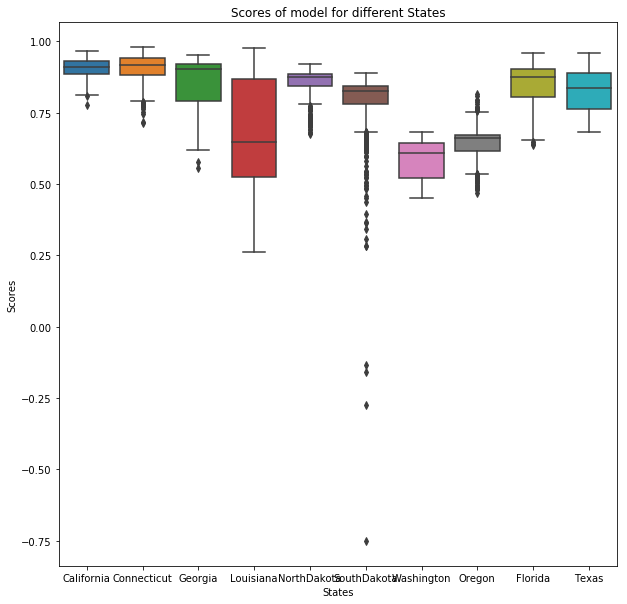

In [19]:
Scores = {'California': Cali.Scores, 'Connecticut': Con.Scores, 'Georgia': Geor.Scores,
         'Louisiana': Louis.Scores, 'NorthDakota': NoDa.Scores, 'SouthDakota':SoDa.Scores,
         'Washington': Wash.Scores,'Oregon': Orgo.Scores,'Florida': Flor.Scores,'Texas': Texa.Scores}
results = pd.DataFrame(data=Scores)

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
im = sns.boxplot(data=results, ax=ax)
im.set_title('Scores of model for different States')
im.set_ylabel('Scores')
im.set_xlabel('States')

plt.show()

# Result

The aim of this challege was to optimize a linear regession model with crime data of New York state to predict property crimes in other states. After the statistical evaluation the model was revised to the following parameters:
$$ Property crime = \alpha + Population + Murder(numerical) + Robbery(numerical)$$


When tested on crime data of other states, the model performed well with scores ranging from .85 - 0.9 for states like California, Connecticut, Florida and Texas.
Whereas, for Georgia, Louisiana, South Dakota, Washington and Orgeon the scores are lower and repeated analysis of partial data sets resulted in large variability.

This indicates that training the model only on data from New York State is not sufficient to make precise prediction for all States. Presumably, the model works well in states that have a similar population structure like New York State. Where as states with lower population density can not be modeled well.

To solve this issue, it would be nessary to sample data from different states into the training set and at the same time introduce further variables for population density, and binary location variables for (East, West, Middle...).